In [46]:
# !pip install torch
import torch

In [47]:
# !pip install torchvision

In [48]:

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader 
trainset = datasets.FashionMNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)


In [49]:
testset=datasets.FashionMNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [50]:
classes=trainset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [51]:
# !pip install matplotlib

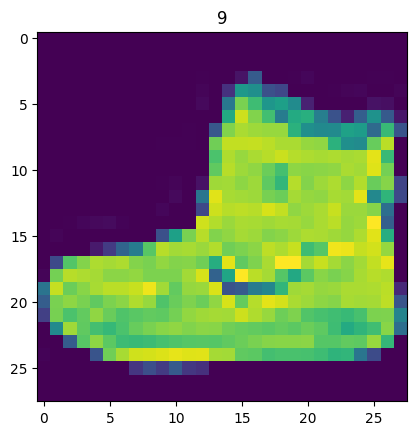

In [52]:
image,label=trainset[0]
import matplotlib.pyplot as plt
plt.imshow(image.squeeze())
plt.title(label)
plt.show()

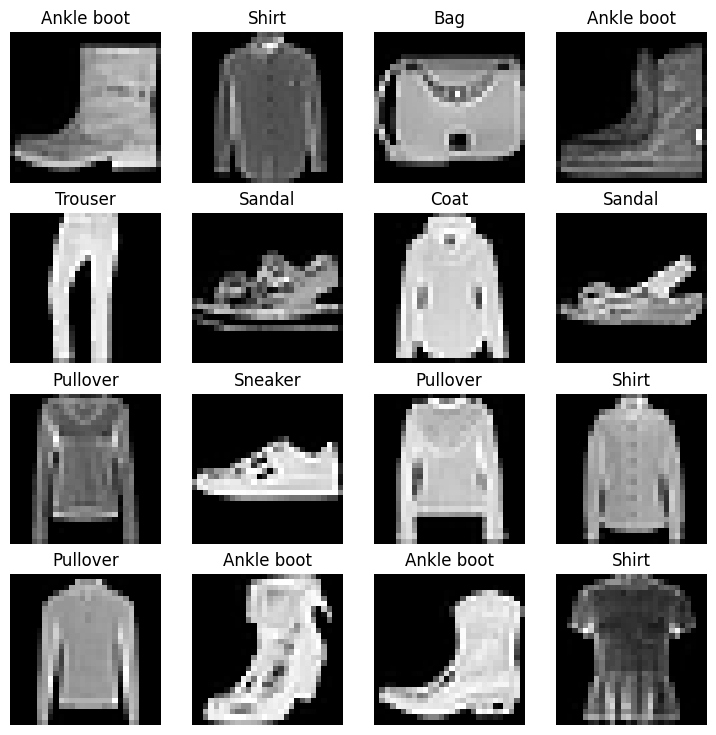

In [53]:
torch.manual_seed(42)
fig=plt.figure(figsize=(9,9))
row,col=4,4
for i in range (1,row*col+1):
    index=torch.randint(0,len(trainset),size=[1]).item()
    image,label=trainset[index]
    fig.add_subplot(row,col,i)
    plt.imshow(image.squeeze(),cmap='gray')
    plt.title(classes[label])
    plt.axis(False)


In [54]:
train_dataloader=DataLoader(
    dataset=trainset,
    batch_size=32,
    shuffle=True
)
test_dataloader=DataLoader(
    dataset=testset,
    batch_size=32,
    shuffle=True
)


In [55]:
batch=next(iter(train_dataloader))
image,label=batch
image.shape
label.shape

torch.Size([32])

In [56]:
train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape
train_labels_batch.shape

torch.Size([32])

In [57]:
from torch import nn
class ImageClassifier(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super().__init__()
        self.block_1=nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_shape,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_shape,
                out_channels=hidden_shape,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2=nn.Sequential(
            nn.Conv2d(hidden_shape,hidden_shape,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_shape,hidden_shape,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_shape*7*7,out_features=output_shape)
        )
    def forward(self,x:torch.tensor)->torch.tensor:
        ans=self.block_1(x)
        ans=self.block_2(ans)
        ans=self.classifier(ans)
        return ans
    
torch.manual_seed(42)
model_0=ImageClassifier(input_shape=1,hidden_shape=10,output_shape=len(classes))
model_0  

ImageClassifier(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [58]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [59]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_0.parameters(),lr=0.005)

In [60]:
import tqdm
from timeit import default_timer as Timer
from torchmetrics import Accuracy
train_time_start = Timer()
epochs = 10
num_classes=len(classes)
accuracy = Accuracy(task='multiclass', num_classes=num_classes)
for epoch in tqdm.tqdm(range(epochs),desc='Training'):
    total_loss=0.0
    accuracy.reset()
    for batch, (x, y) in enumerate(train_dataloader):
        y_pred=model_0(x)
        loss=loss_fn(y_pred,y)
        y_convpred=torch.softmax(y_pred,dim=1).argmax(dim=1)
        acc=accuracy(y_convpred, y)
        total_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(f"epoch: {epoch}\nbatch: {batch}\n loss: {loss}\n accurracy:{acc}\n")
    average_loss=total_loss/len(train_dataloader)
    accu=accuracy.compute()
    tqdm.tqdm.write(f"epoch: {epoch}\n average_loss: {average_loss}\n accuracy:{accu}\n")



Training:  10%|█         | 1/10 [00:27<04:03, 27.10s/it]

epoch: 0
 average_loss: 1.3318455074469249
 accuracy:0.5181999802589417



Training:  20%|██        | 2/10 [00:52<03:30, 26.26s/it]

epoch: 1
 average_loss: 0.6627467632770538
 accuracy:0.7609999775886536



Training:  30%|███       | 3/10 [01:16<02:55, 25.03s/it]

epoch: 2
 average_loss: 0.5677448837518692
 accuracy:0.7937333583831787



Training:  40%|████      | 4/10 [01:39<02:26, 24.46s/it]

epoch: 3
 average_loss: 0.49808373858133953
 accuracy:0.8205166459083557



Training:  50%|█████     | 5/10 [02:03<02:00, 24.06s/it]

epoch: 4
 average_loss: 0.45256446809768675
 accuracy:0.838616669178009



Training:  60%|██████    | 6/10 [02:26<01:34, 23.72s/it]

epoch: 5
 average_loss: 0.4250863270084063
 accuracy:0.8483333587646484



Training:  70%|███████   | 7/10 [02:49<01:11, 23.68s/it]

epoch: 6
 average_loss: 0.4054808406472206
 accuracy:0.8546666502952576



Training:  80%|████████  | 8/10 [03:13<00:47, 23.57s/it]

epoch: 7
 average_loss: 0.38822990081707637
 accuracy:0.8622833490371704



Training:  90%|█████████ | 9/10 [03:36<00:23, 23.47s/it]

epoch: 8
 average_loss: 0.37447165784041087
 accuracy:0.8667166829109192



Training: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it]

epoch: 9
 average_loss: 0.3639795603990555
 accuracy:0.8706833124160767



In [61]:
def eval_mode(model,test_dataloader,loss_fn,num_class=9):
    model.eval()
    total_loss=0.0
    test_accuracy=Accuracy(task='multiclass',num_classes=num_class)
    start_time=Timer()
    all_pred=[]
    all_target=[]
    with torch.inference_mode():
        for batch,(x,y) in enumerate(test_dataloader):
            y_pred=model(x)
            loss=loss_fn(y_pred,y)
            total_loss+=loss
            pred=torch.softmax(y_pred,dim=1).argmax(dim=1)
            acc=test_accuracy(pred,y)
            all_pred.append(pred)
            all_target.append(y)
            if(batch%100==0):
                print(f"batch: {batch}\nloss: {loss}\nacc: {acc}\n")
    final_accuracy=test_accuracy.compute()
    average_loss=total_loss/len(test_dataloader)
    eval_time=Timer()-start_time
    y_pred_tensor=torch.cat(all_pred,dim=0)
    y_pred_target=torch.cat(all_target,dim=0)
    print(f"final_accuracy: {final_accuracy}\n")
    print(f"average_loss: {average_loss}\n")
    print(f"eval_time: {eval_time}\n")
    return {
        "accuracy":final_accuracy,
        "average_loss":average_loss,
        "eval_time":eval_time,
        "y_pred_tensor":y_pred_tensor,
        "y_target":y_pred_target
    }

In [62]:
evaluated=eval_mode(model=model_0,test_dataloader=test_dataloader,loss_fn=loss_fn,num_class=num_classes)

batch: 0
loss: 0.31753262877464294
acc: 0.90625

batch: 100
loss: 0.4604775905609131
acc: 0.8125

batch: 200
loss: 0.23188607394695282
acc: 0.90625

batch: 300
loss: 0.1719726175069809
acc: 0.90625

final_accuracy: 0.857699990272522

average_loss: 0.3988513946533203

eval_time: 2.217929999998887



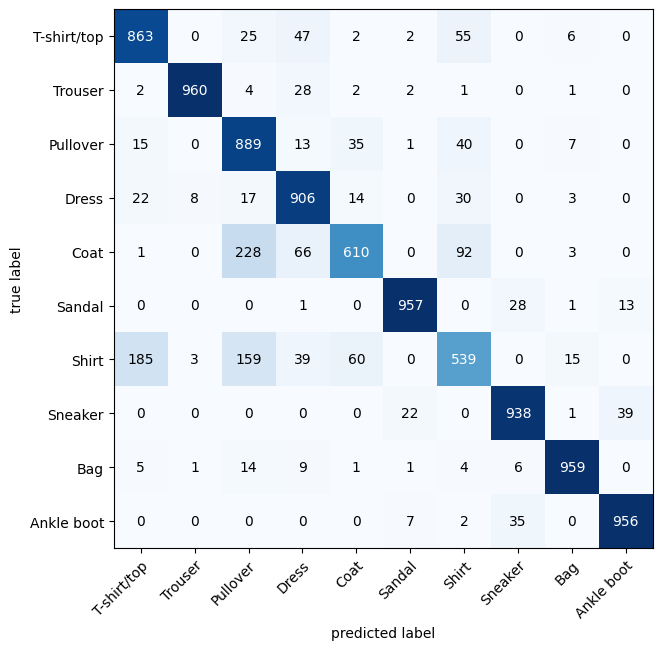

In [63]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat=ConfusionMatrix(num_classes=num_classes,task='multiclass')
confmat_tensor=confmat(preds=evaluated["y_pred_tensor"],target=evaluated["y_target"])
fig,ax=plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=classes,
    figsize=(10,7)
)

In [64]:
import torch
import os
model_path="model"
os.makedirs(model_path,exist_ok=True)
model_name=model_path+"/"+'model_weights.pth'
torch.save(model_0.state_dict(),model_name)


In [65]:
classes[0]
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']